In [1]:
import random
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Input

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
print(max(len(w) for w in words))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### build the vocab of chars and lookup tables

In [21]:
# build the vocab of chars and lookup tables
chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [22]:
# shuffle the words
random.seed(42)
random.shuffle(words)

In [208]:
block_size = 8 # context length

def build_dataset(words):
    X, Y = [], [] # inp and op
    for word in words:
        # context initialization: for the first letter it will just be '.' 8 times because the context size is 8 rn!
        context = [0] * block_size 
        # create input i.e context from each word
        for char in word + '.':
            X.append(context)
            y_ix = stoi_lookup[char]
            Y.append(y_ix)
            context = context[1:] + [y_ix]

    X = torch.tensor(X) # or torch.tensor
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y

tr_win_end = int(0.8 * len(words))
test_win_end = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:tr_win_end])  # use to optimise the model params
X_val, Y_val = build_dataset(words[tr_win_end: test_win_end]) # use for hyperparameters tuning(hidden layer size, embedding size etc)
X_test, Y_test = build_dataset(words[test_win_end:]) # use for evaluating the performance of the model

shapes:  torch.Size([182580, 8]) torch.Size([182580])
shapes:  torch.Size([22767, 8]) torch.Size([22767])
shapes:  torch.Size([22799, 8]) torch.Size([22799])


In [209]:
for x, y in zip(X_tr[:15], Y_tr[:15]):
    print("".join(itos_lookups[i.item()] for i in x), '----->', itos_lookups[y.item()])

........ -----> e
.......e -----> b
......eb -----> r
.....ebr -----> i
....ebri -----> m
...ebrim -----> a
..ebrima -----> .
........ -----> h
.......h -----> i
......hi -----> l
.....hil -----> t
....hilt -----> o
...hilto -----> n
..hilton -----> .
........ -----> j



![Batch Normalization](batch_norm.png)

In [219]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # fan_in ** 0.5 is kaiming init for good initalization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # w * x + b
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def params(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum # for updating the running buffers(mean and var)
        self.training = True # track buffers or not

        # batch norm params - scale and shift
        self.gamma = torch.ones(dim) # scale by default 1 
        self.beta = torch.zeros(dim) # shift by default 0

        # track running mean and var with buffers
        self.running_mean = torch.zeros(dim) # for Gaussian it should be 0
        self.running_var = torch.ones(dim) # for Gaussian it should be 1

    def __call__(self, x):
        # forward pass
        
        # ------------ normalize the mini batch with mean and var ------------
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3: # for 3 dimensions, take mean and var over (0, 1) dim
                dim = (0, 1)
            # calculate mean and var for every mini batch while training
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        # if we are not training then the mean and variance will be inferred from the running buffers
        else:
            # used for normalization during evaluation(validation and testing)
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) /torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta # scale and shift
        #-----------------------------------------------------------------------

        # ----------------track buffers-------------
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        # ------------------------------------------
        
        return self.out
    
    def params(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def params(self):
        return []

modularizing the embeddings and concatenation/flattening of the vectors

In [220]:
# embeddings - previously emb = C[X]
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def params(self):
        return [self.weight]

# concatenation/flattening - previously emb_cat = emb.view(emb.shape[0], -1)
class FlattenConsecutive:
    def __init__(self, n):
        # number of consecutive elements that we want to concatenate
        self.n = n # 2 for wavenet
        
    def __call__(self, x):
        B, T, C = x.shape # 4, 8, 10 for the example 
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1: # if this dimension is 1, e.g (4, 1, 200), we might as well return (4, 200)
            x = x.squeeze(1) # squeeze out this dimension

        self.out = x
        return self.out

    def params(self):
        return []

containerizing(akin to PyTorch's container) the layers

In [221]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        # call the layers Sequentially
        for layer in self.layers:
            x = layer(x)
        self.out = x
        # return the output of the layers at the end
        return self.out
    
    def params(self):
        # params of all the layers
        return [p for layer in self.layers for p in layer.params()]

In [222]:
torch.manual_seed(42)

how to change the network for WaveNet?

Lets take a batch of 4 examples, the first linear layer looks like

(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape i.e (x @ W + b)

we have 8 chars in a context:
say 1, 2, 3, 4, 5, 6, 7, 8

while implementing wavenet, we will be taking two at a time like this (1, 2), (3, 4), (5, 6), (7, 8)

these 4 groups need to be processed in parellel, so we need to change the layer cofigs

how will the x(emb_cat) change?
- it would take (4, 20) instead of (dim_embd * block_size) = (80)

how will the W change?

- it would be (20, n_hidden), 4 groups of two characters at a time, instead of (80, n_hidden)
we can do this with .view(),

**change the flatten layer implementation and call accordingly!**

How will the BatchNorm change if at all? 

We calculated mean and var over dim 0 when the shape was (a, b) but now the shape is (a, b, c) so we will have take these stats over dim 0 and 1

In [231]:
dim_embd = 24   # dimensionality of the character embedding vectors i.e vector size
n_hidden = 128 # changed to 68 to keep the number of params to model approximately to same as our MLP

model = Sequential([
    Embedding(vocab_size, dim_embd),
    # FlattenConsecutive - two characters at a time, dim_embd * 2 = 20
    FlattenConsecutive(2), Linear(dim_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# initialization
with torch.no_grad():
    # for the output layer scale down the weights so we arent confidently wrong at init
    model.layers[-1].weight *= 0.1

params = model.params()

print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

76579


In [232]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    # minintach construction
    ix = torch.randint(0, X_tr.shape[0], (batch_size, ))
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # forward pass
    # old way without container
    # for layer in layers:
    #     x = layer(x)
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    # set the gradients to 0 for each backward pass, dont accumulate them from the prev bacth
    for p in params:
        p.grad = None
    loss.backward()
    
    l_rate = 0.1 if step < 150000 else 0.01 # learning rate with decay
    
    # update params according to the grad and learning rate
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())
    
    # if step >= 1000:
    #     break

# print(f'{loss=}')

      0/ 200000:3.2998
  10000/ 200000:1.7676
  20000/ 200000:2.3884
  30000/ 200000:1.9698
  40000/ 200000:2.6673
  50000/ 200000:1.8961
  60000/ 200000:1.7927
  70000/ 200000:2.1857
  80000/ 200000:1.7376
  90000/ 200000:2.1071
 100000/ 200000:2.0856
 110000/ 200000:1.8888
 120000/ 200000:1.7540
 130000/ 200000:2.0079
 140000/ 200000:2.0151
 150000/ 200000:2.2124
 160000/ 200000:1.9667
 170000/ 200000:1.8774
 180000/ 200000:1.9853
 190000/ 200000:1.2605


average loss distribution for every 1000 steps

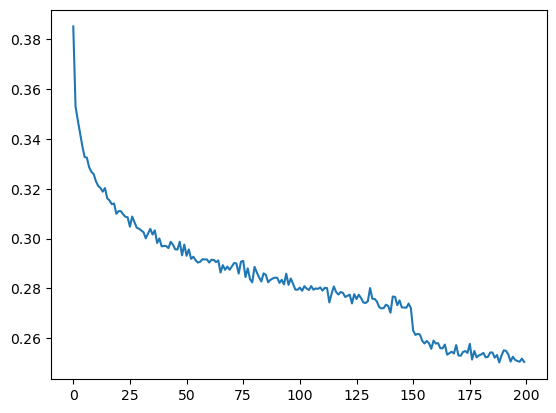

In [233]:
plt.plot(torch.tensor(losses_at_idx).view(-1, 1000).mean(1));

Evaluate the model

In [234]:
for layer in model.layers:
    layer.training = False

In [235]:
@torch.no_grad()
def split_loss(split_name):
    # forward pass
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    print(split_name, loss.item())

split_loss('train')
split_loss('val')

train 1.7660999298095703
val 1.988011360168457


with context size = 3:
- train 2.056
- val 2.105

with context size = 8:
- train 1.917
- val 2.026

with context size = 8, vector size = 10,  hidden layer with 64 neurons
- train 1.910
- val 2.018

with context size = 8, vector size = 24,  hidden layer with 128 neurons
- train 1.766
- val 1.988

the train and val losses are similar, so the model is not overfitting

sampling from the model

In [249]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # make sure that the layer.training is set False or else we will be giving a single input to a batch norm, 
        # var of single number is nan, mean will be ok though
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1) # calculate probs from logits with softmax
        ix = torch.multinomial(probs, num_samples = 1).item()
        out.append(ix)
        context = context[1:] + [ix] # update the context
        if ix == 0: # EOS
            break

    print("".join(itos_lookups[i] for i in out))

durenze.
rose.
brany.
raynan.
adij.
joylah.
calline.
wilson.
shameen.
cashison.
hanneh.
denone.
naviera.
annistofio.
geovanne.
allsana.
nahmayo.
juliano.
dayson.
hana.


for analysing the layers with an example

In [224]:
ix = torch.randint(0, X_tr.shape[0], (4, )) # batch of 4 examples
Xb, Yb = X_tr[ix], Y_tr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 16,  8,  9, 12],
        [ 0,  0,  0, 13,  1, 12,  3, 15],
        [ 0,  0,  0,  8,  5, 18, 13,  5],
        [ 1, 18,  9, 19, 20,  5, 12, 12]])

In [225]:
for layer in model.layers:
    print(layer.__class__.__name__,':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__